In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

sys.path.append('..')
from multitask.rlc_generate import visualize_tasks, generate_rlc_task_params, simulate_rlc_system, generate_colored_noise

DATA_DIR = '/system/user/publicdata/meta_learning/ode/rlc_dataset-resistor_range1_14-capacitor_range100_800-inductor_range20_140'

In [2]:
test_task_dir = Path(DATA_DIR) / 'test'
test_tasks_names = [task_file.stem for task_file in test_task_dir.glob('*.npy')]

In [3]:
task = test_tasks_names[0]
{p.split(':')[0]:float(p.split(':')[1]) for p in task.split('_')}

{'R': 2.0005479452697545,
 'L': 5.963974503396337e-05,
 'C': 4.4174291934218044e-07}

In [4]:
test_task_params = [{p.split(':')[0]:float(p.split(':')[1]) for p in task.split('_')} for task in test_tasks_names]

In [41]:
from typing import List, Dict
def visualize_tasks_paper(
        n_tasks=100,
        task_models: List[Dict[str, float]] = None,
        plot_nominal_model: bool= False,
        n_steps:int = 2000, 
        figsize=(10,6), 
        cmap='viridis', 
        alpha=0.6, 
        color_seed=0
):
    # inputs
    u, te = generate_colored_noise(bandwidth=80e3, Ts=1e-6, n_steps=n_steps)    
    if plot_nominal_model:
        nominal_model = {"C": 270e-9, "L": 50e-6, "R": 3.0}
        # simulate systems
        nominal_traj = simulate_rlc_system(nominal_model, u, te)

    task_trajectories = []
    for task_model in task_models[:n_tasks]:
        traj = simulate_rlc_system(task_model, u, te)
        task_trajectories.append(traj)

    name_template = 'R:{R}_L:{L}_C:{C}'

    # plot trajectories
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)
    plot_steps = n_steps

    # color idxs
    rng = np.random.default_rng(seed=color_seed)
    # random_color_indices = rng.permutation(np.arange(len(cmap.colors)))
    random_color_indices = rng.integers(len(cmap.colors), size=n_tasks)
    # random_color_indices = np.arange(len(cmap.colors))
    for i, task_traj in enumerate(task_trajectories):
        axs[0].plot(task_traj[:plot_steps, 0], c=cmap.colors[random_color_indices[i]], alpha=alpha)
        # axs[1].plot(task_traj[:plot_steps, 1])
    if plot_nominal_model:
        axs[0].plot(nominal_traj[:plot_steps, 0],
                   'r',
                   lw=2,
                   label=name_template.format(**nominal_model))
        # axs[1].plot(nominal_traj[:plot_steps, 1],
        #            'r',
        #            lw=2,
        #            label=name_template.format(**nominal_model))
    # axs[0].legend(frameon=False, loc=(1, 0))

    axs[1].plot(u[:plot_steps], '#003f5c')
    axs[1].set_xlabel('Time steps')
    axs[1].set_ylabel('Input voltage')
    # axs[1].set_ylabel('Inductor current (A)')
    axs[0].set_ylabel('Capacitor voltage')
    for ax in axs:
        ax.grid(alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return fig

In [15]:
colors = ['#003f5c',
'#054162',
'#0e4468',
'#17466e',
'#204874',
'#294a79',
'#334c7e',
'#3c4d83',
'#464e87',
'#504f8b',
'#5a508e',
'#655191',
'#6f5193',
'#7a5195',
'#845196',
'#8f5196',
'#995196',
'#a35095',
'#ad5094',
'#b75092',
'#c04f8f',
'#c9508c',
'#d25088',
'#da5184',
'#e2527f',
'#e9547a',
'#ef5675',
'#f5596f',
'#fa5d69',
'#fe6263',
'#ff675c',
'#ff6d55',
'#ff734e',
'#ff7946',
'#ff803e',
'#ff8736',
'#ff8f2d',
'#ff9623',
'#ff9e15',
'#ffa600']
cmap = mpl.colors.ListedColormap(colors=colors)

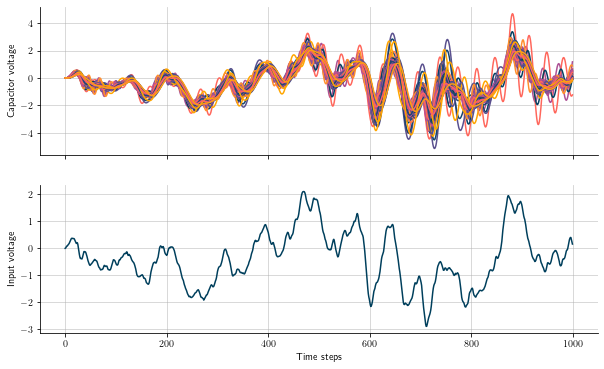

In [42]:
from matplotlib import rc
os.environ["PATH"] = "/system/user/gauch/.texlive2021/bin/x86_64-linux" + os.pathsep + os.environ["PATH"]
rc('text', usetex=True)
fig = visualize_tasks_paper(50, task_models=test_task_params, n_steps=1000, cmap=cmap, alpha=1.0, color_seed=1)
fig.savefig('rlc-tasks-input-outputs.pdf', bbox_inches="tight")